<a href="https://colab.research.google.com/github/tathagatsathe/HumanActivityRecognition/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, pandas as pd, numpy as np,matplotlib.pyplot as plt, seaborn as sns
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, accuracy_score, roc_auc_score, classification_report
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import pickle

In [3]:
sns.set(rc={'figure.figsize':(20,10)})

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
df = pd.DataFrame()

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Datasets/wisdm-dataset/arff_files'):
  for filename in filenames:
    if(filename.split('.')[1] == 'arff'):
      data = arff.loadarff(os.path.join(dirname, filename))
      if(df.empty):
        df_temp = pd.DataFrame(data[0])
        df_temp['file'] = filename.split('.')[0]
        df = df_temp.copy()
      else:
        df_temp = pd.DataFrame(data[0])
        df_temp['file'] = filename.split('.')[0]
        df = df.append(df_temp)

In [6]:
cols = [col.strip('"') for col in df.columns]
df.columns = cols
df.reset_index(inplace=True,drop=True)

In [ ]:
df.to_csv('HumanActivityRecognition.csv',header=True)

In [7]:
df.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class,file
0,b'A',0.0,0.0,0.0,0.0,0.02,0.195,0.275,0.240,0.205,...,0.475888,-0.424800,-0.540664,0.742245,0.180966,0.028993,0.653510,13.6987,b'1603',data_1603_accel_watch
1,b'A',0.0,0.0,0.0,0.0,0.00,0.190,0.465,0.310,0.035,...,0.403662,-0.543209,-0.657680,0.661040,0.223324,-0.043878,0.455660,12.3760,b'1603',data_1603_accel_watch
2,b'A',0.0,0.0,0.0,0.0,0.00,0.100,0.610,0.270,0.020,...,0.358224,-0.526723,-0.542331,0.768224,0.268513,0.066037,0.664313,12.4360,b'1603',data_1603_accel_watch
3,b'A',0.0,0.0,0.0,0.0,0.00,0.135,0.585,0.240,0.035,...,0.354046,-0.562874,-0.573174,0.750614,0.270042,-0.030761,0.619433,12.2830,b'1603',data_1603_accel_watch
4,b'A',0.0,0.0,0.0,0.0,0.00,0.115,0.555,0.265,0.065,...,0.367856,-0.455862,-0.561776,0.766964,0.382146,0.091794,0.672474,12.5075,b'1603',data_1603_accel_watch


In [8]:
df['ACTIVITY'] = df['ACTIVITY'].str.decode("utf-8")
df['class'] = df['class'].str.decode("utf-8")

df['sensor'] = df['file'].str.split('_').str[2]
df['device'] = df['file'].str.split('_').str[3]
df.drop('file',axis=1,inplace=True)

In [9]:
df = pd.get_dummies(df,drop_first=True,columns=['sensor','device'])

In [10]:
df.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class,sensor_gyro,device_watch
0,A,0.0,0.0,0.0,0.0,0.02,0.195,0.275,0.240,0.205,...,-0.424800,-0.540664,0.742245,0.180966,0.028993,0.653510,13.6987,1603,0,1
1,A,0.0,0.0,0.0,0.0,0.00,0.190,0.465,0.310,0.035,...,-0.543209,-0.657680,0.661040,0.223324,-0.043878,0.455660,12.3760,1603,0,1
2,A,0.0,0.0,0.0,0.0,0.00,0.100,0.610,0.270,0.020,...,-0.526723,-0.542331,0.768224,0.268513,0.066037,0.664313,12.4360,1603,0,1
3,A,0.0,0.0,0.0,0.0,0.00,0.135,0.585,0.240,0.035,...,-0.562874,-0.573174,0.750614,0.270042,-0.030761,0.619433,12.2830,1603,0,1
4,A,0.0,0.0,0.0,0.0,0.00,0.115,0.555,0.265,0.065,...,-0.455862,-0.561776,0.766964,0.382146,0.091794,0.672474,12.5075,1603,0,1


In [11]:
df.shape

(75099, 95)

In [12]:
le = LabelEncoder()
df['ACTIVITY'] = le.fit_transform(df['ACTIVITY'])

labels_activity = df['ACTIVITY'].unique()

In [13]:
feat_cols = df.iloc[:,1:-3].columns
corr = df[feat_cols].corr()

In [14]:
tril_index = np.tril_indices_from(corr)
corr_arr = np.array(corr)
corr_arr[np.tril_indices_from(corr)] = np.nan
corr = pd.DataFrame(corr_arr, columns=corr.columns, index=corr.index)

In [15]:
cols_to_drop = [column for column in corr.columns if any(corr[column] > 0.95)]

In [16]:
corr = corr.stack().to_frame().reset_index().rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'correlation'})
corr['abs_correlation'] = corr['correlation'].abs()

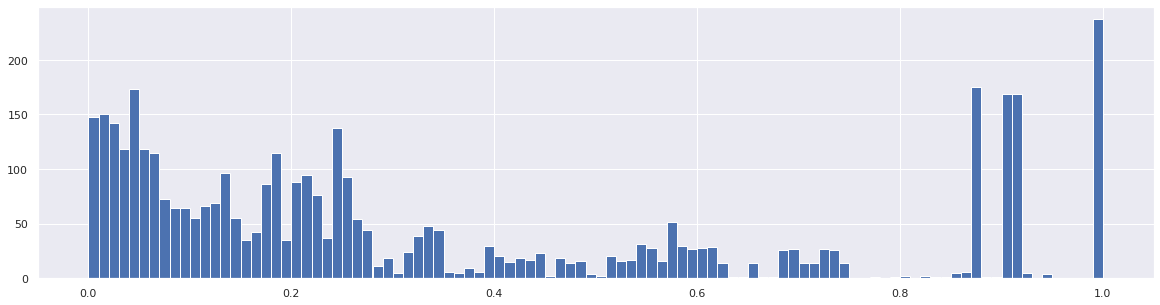

In [17]:
corr['abs_correlation'].hist(bins=100, figsize=(20,5))

In [18]:
corr.sort_values(by='abs_correlation', ascending=False).query('abs_correlation>0.8')

,feature_1,feature_2,correlation,abs_correlation
3600,YMFCC1,YMFCC3,1.000000,1.000000
3599,YMFCC1,YMFCC2,1.000000,1.000000
3661,YMFCC3,YMFCC5,1.000000,1.000000
3663,YMFCC3,YMFCC7,1.000000,1.000000
3630,YMFCC2,YMFCC3,1.000000,1.000000
...,...,...,...,...
2823,YSTANDDEV,ZVAR,0.836037,0.836037
2617,XABSOLDEV,ZVAR,0.829959,0.829959
2668,YABSOLDEV,XVAR,0.829190,0.829190
2670,YABSOLDEV,ZVAR,0.809836,0.809836


In [19]:
df.drop(columns=cols_to_drop,inplace=True)
df.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class,sensor_gyro,device_watch
0,0,0.0,0.0,0.0,0.0,0.02,0.195,0.275,0.240,0.205,...,-0.424800,-0.540664,0.742245,0.180966,0.028993,0.653510,13.6987,1603,0,1
1,0,0.0,0.0,0.0,0.0,0.00,0.190,0.465,0.310,0.035,...,-0.543209,-0.657680,0.661040,0.223324,-0.043878,0.455660,12.3760,1603,0,1
2,0,0.0,0.0,0.0,0.0,0.00,0.100,0.610,0.270,0.020,...,-0.526723,-0.542331,0.768224,0.268513,0.066037,0.664313,12.4360,1603,0,1
3,0,0.0,0.0,0.0,0.0,0.00,0.135,0.585,0.240,0.035,...,-0.562874,-0.573174,0.750614,0.270042,-0.030761,0.619433,12.2830,1603,0,1
4,0,0.0,0.0,0.0,0.0,0.00,0.115,0.555,0.265,0.065,...,-0.455862,-0.561776,0.766964,0.382146,0.091794,0.672474,12.5075,1603,0,1


In [99]:
df['ACTIVITY'].value_counts(normalize=True)

12    0.058123
14    0.057937
13    0.057165
10    0.057045
4     0.056352
3     0.056113
17    0.055700
15    0.055593
1     0.055593
16    0.055580
6     0.055394
7     0.055087
0     0.055034
8     0.054808
11    0.054408
9     0.053623
5     0.053343
2     0.053103
Name: ACTIVITY, dtype: float64

In [20]:
feat_cols = df.columns[1:-3]

In [21]:
def scores(model_name,y_test,y_pred,y_prob=[]):
  precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test,y_pred)
  if(len(y_prob)!=0):
    auc = roc_auc_score(label_binarize(y_test,classes=labels_activity),y_prob,average='weighted')
  else:
    auc= np.nan
  return pd.DataFrame(pd.Series({'precision':precision,'recall':recall,'fscore':fscore,'accuracy':accuracy,'auc':auc},name=model_name)).T

In [70]:
model_scores = pd.DataFrame(columns=['precision', 'recall', 'fscore', 'accuracy', 'auc'])

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[feat_cols],df['ACTIVITY']))

X_train, y_train = df.loc[train_idx, feat_cols], df.loc[train_idx, 'ACTIVITY']
X_test, y_test = df.loc[test_idx, feat_cols], df.loc[test_idx, 'ACTIVITY']

In [23]:
X_train.shape

(52569, 52)

In [24]:
len(y_train.unique())

18

In [25]:
%%time
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)

CPU times: user 58.4 s, sys: 119 ms, total: 58.5 s
Wall time: 58.5 s


LogisticRegression(solver='liblinear')

In [26]:
%%time
y_prob_lr = lr.predict_proba(X_test)
y_pred_lr = lr.predict(X_test)

CPU times: user 51.5 ms, sys: 28.2 ms, total: 79.6 ms
Wall time: 45.9 ms


In [ ]:
# lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [ ]:
# lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

In [73]:
model_scores = model_scores.append(scores('lr',y_test,y_pred_lr,y_prob_lr))
scores('lr',y_test,y_pred_lr,y_prob_lr)

,precision,recall,fscore,accuracy,auc
lr,0.323903,0.335553,0.321769,0.335553,0.835467


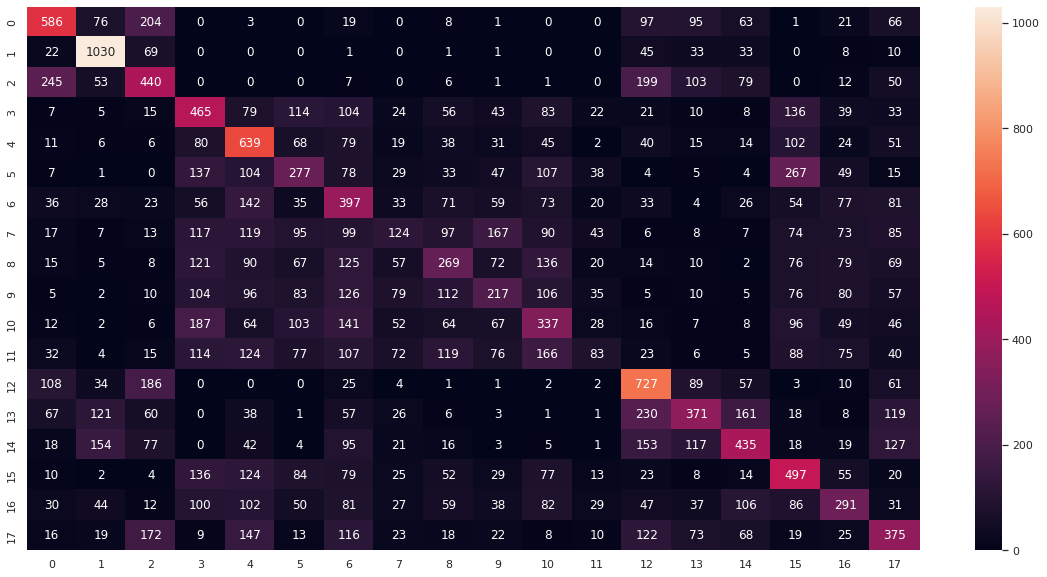

In [28]:
sns.heatmap(confusion_matrix(y_test,y_pred_lr),annot=True,fmt='d')

In [29]:
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)

In [34]:
%%time
neighbors = np.linspace(3,15,13,dtype=int)

knn_scores = pd.DataFrame()

for neighbor in neighbors:
  knn = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1,weights="distance")
  knn = knn.fit(X_train_s,y_train)
  y_pred_knn_d = knn.predict(X_test_s)
  if(knn_scores.empty):
    knn_scores = scores('knn '+ str(neighbor),y_test,y_pred_knn_d)
  else:
    knn_scores = knn_scores.append(scores('knn '+ str(neighbor),y_test,y_pred_knn_d))

CPU times: user 8min 52s, sys: 17 s, total: 9min 9s
Wall time: 7min 12s


In [35]:
knn_scores

,precision,recall,fscore,accuracy,auc
knn 3,0.699917,0.702574,0.700153,0.702574,NaN
knn 4,0.704544,0.706835,0.704291,0.706835,NaN
knn 5,0.705211,0.707235,0.704459,0.707235,NaN
knn 6,0.705441,0.707368,0.704442,0.707368,NaN
knn 7,0.703057,0.704838,0.701650,0.704838,NaN
knn 8,0.699743,0.701509,0.698342,0.701509,NaN
knn 9,0.697448,0.699157,0.695864,0.699157,NaN
knn 10,0.697582,0.699112,0.695782,0.699112,NaN
knn 11,0.694215,0.695473,0.691980,0.695473,NaN
knn 12,0.691508,0.692676,0.689033,0.692676,NaN


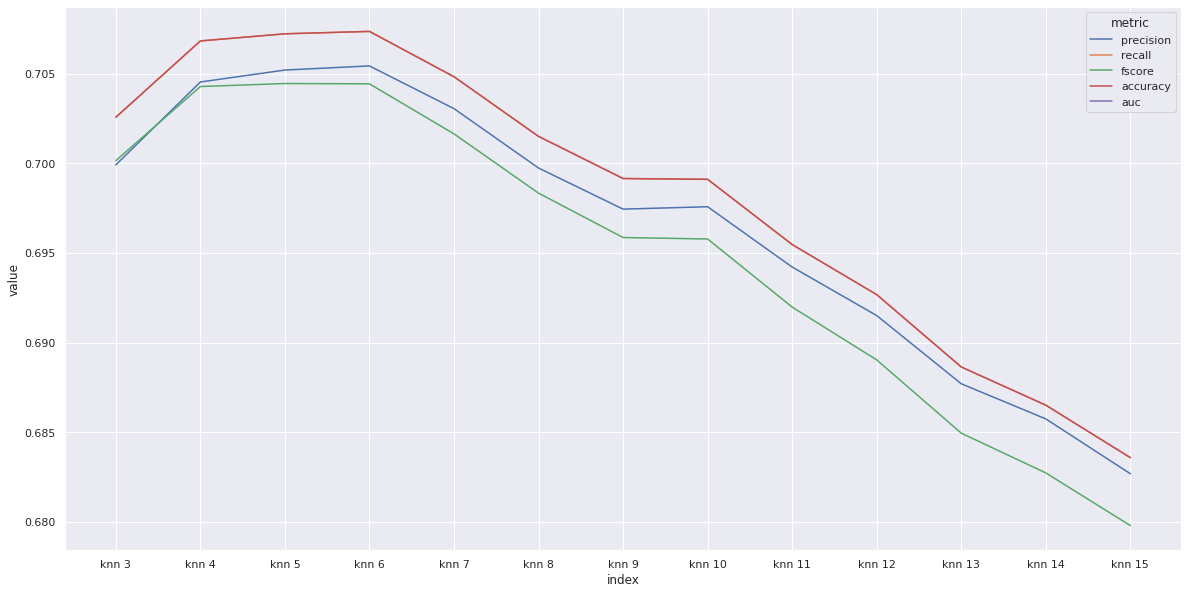

In [36]:
knn_scores_melt = knn_scores.melt(var_name='metric',value_name='value',ignore_index=False).reset_index()
sns.lineplot(data=knn_scores_melt,x='index',y='value',hue='metric')

In [37]:
%%time
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1,weights="distance")
knn = knn.fit(X_train_s,y_train)

CPU times: user 9.08 ms, sys: 1.94 ms, total: 11 ms
Wall time: 13.4 ms


In [38]:
%%time
y_pred_knn = knn.predict(X_test_s)

CPU times: user 41.5 s, sys: 1.32 s, total: 42.8 s
Wall time: 34.1 s


In [75]:
model_scores = model_scores.append(scores('knn',y_test,y_pred_knn))
scores('knn',y_test,y_pred_knn)

,precision,recall,fscore,accuracy,auc
knn,0.705441,0.707368,0.704442,0.707368,NaN


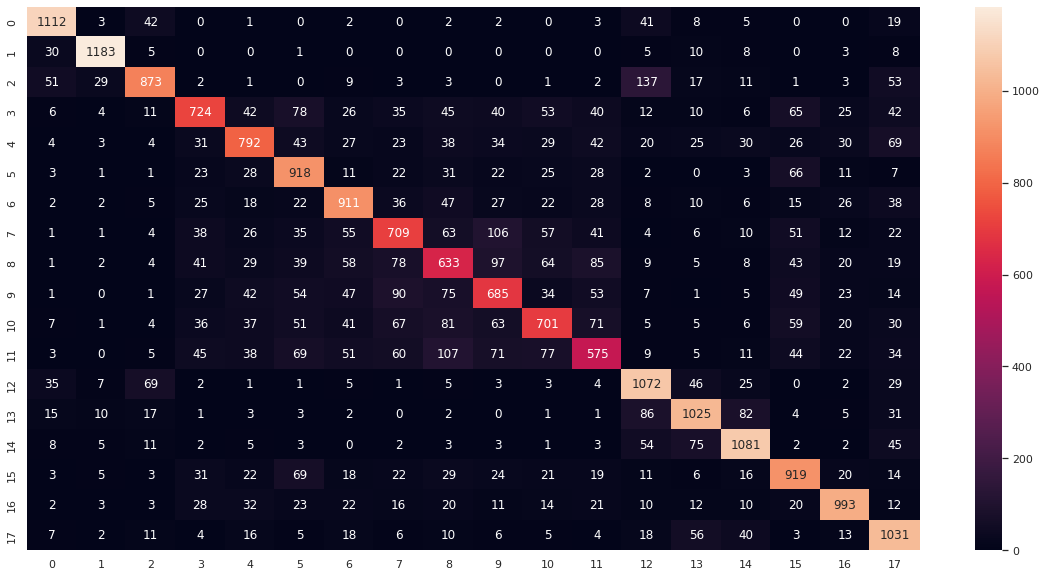

In [40]:
sns.heatmap(confusion_matrix(y_test,y_pred_knn),annot=True,fmt='d')

In [ ]:
# SVC_Gaussian = SVC(kernel="rbf",gamma=0.5)

# SVC_Gaussian.fit(X_train,y_train)

In [ ]:
# y_pred_svm = SVC_Gaussian.predict(X_test)

In [41]:
NystroemSVC = Nystroem(kernel="rbf",gamma=1,n_components=100)

X_train_NysSVC = NystroemSVC.fit_transform(X_train_s)
X_test_NysSVC = NystroemSVC.transform(X_test_s)

In [42]:
lsvc = LinearSVC()
lsvc.fit(X_train_NysSVC,y_train)

LinearSVC()

In [43]:
y_pred_svc = lsvc.predict(X_test_NysSVC)

In [76]:
model_scores = model_scores.append(scores("SVM",y_test,y_pred_svc))
scores("SVM",y_test,y_pred_svc)

,precision,recall,fscore,accuracy,auc
SVM,0.240105,0.13391,0.122927,0.13391,NaN


In [45]:
dt = DecisionTreeClassifier(random_state=42)

In [46]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [47]:
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)

In [91]:
model_scores = model_scores.append(scores('decisiontree',y_test,y_pred_dt,y_prob_dt))
scores('decisiontree',y_test,y_pred_dt,y_prob_dt)

,precision,recall,fscore,accuracy,auc
decisiontree,0.580468,0.58047,0.580354,0.58047,0.777904


In [49]:
dt.tree_.max_depth , dt.tree_.node_count

(41, 26573)

In [ ]:
# param_grid = {
#     'max_depth': range(1,dt.tree_.max_depth+1,2),
#     'max_features': range(1,len(dt.feature_importances_)+1)
# }

# GR = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring="accuracy",n_jobs=-1)

In [ ]:
# GR = GR.fit(X_train,y_train)

In [ ]:
# y_pred_dt_gr = GR.predict(X_test)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0205759 to fit



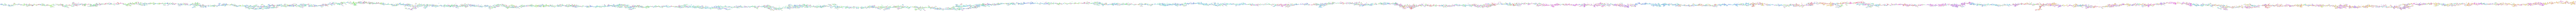

In [ ]:
# dot_data = StringIO()

# export_graphviz(dt,out_file=dot_data, filled=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# file_name = 'human_activity.png'
# graph.write_png(file_name)
# Image(filename=file_name)

In [50]:
RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

In [51]:
%%time
oob_list = list()

for n_trees in [10,50,75,100,150,250,400]:
  RF.set_params(n_estimators=n_trees)

  RF.fit(X_train, y_train)

  oob_err = 1 - RF.oob_score_

  oob_list.append(pd.Series({'n_trees':n_trees, 'oob_score': oob_err}))


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


CPU times: user 3min 14s, sys: 1.77 s, total: 3min 16s
Wall time: 1min 54s


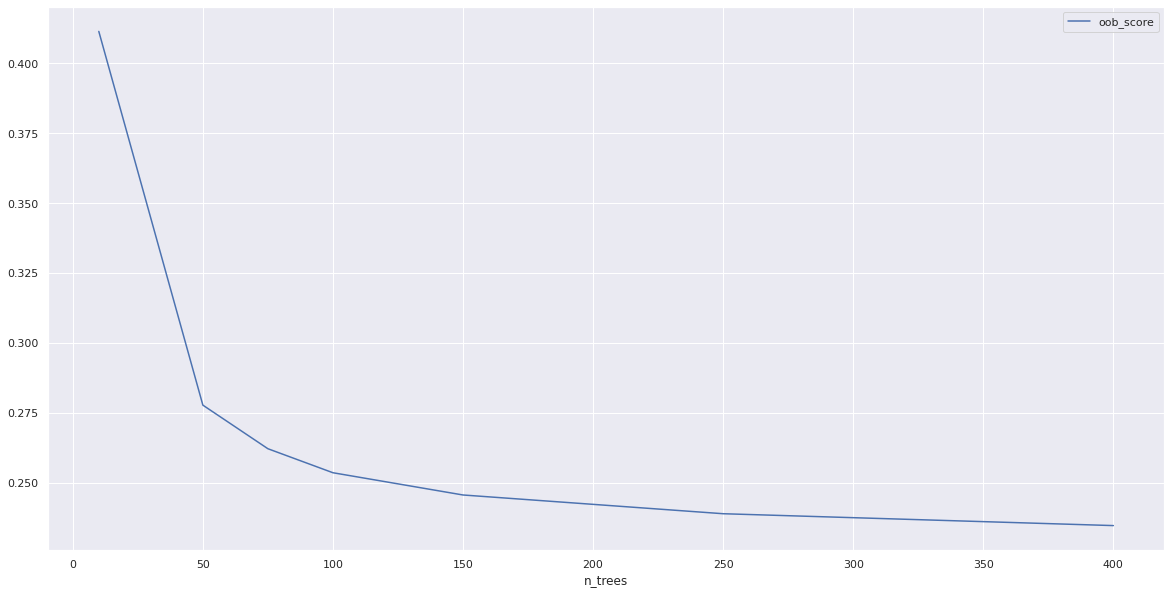

In [52]:
pd.DataFrame(oob_list).set_index('n_trees').plot()

In [78]:
y_pred_rf = RF.predict(X_test)
y_prob_rf = RF.predict_proba(X_test)

In [79]:
model_scores = model_scores.append(scores('RandomForest',y_test,y_pred_rf,y_prob_rf))
scores('RandomForest',y_test,y_pred_rf,y_prob_rf)

,precision,recall,fscore,accuracy,auc
RandomForest,0.774583,0.772925,0.77204,0.772925,0.976283


In [56]:
# %%time

# error_list = list()

# for n_trees in [20,50,75,100,150,250,400]:
#   GR = GradientBoostingClassifier(max_features=5,n_estimators=n_trees,random_state=42)

#   GR.fit(X_train.values, y_train.values)

#   y_pred = GR.predict(X_test.values)

#   error = 1 - accuracy_score(y_test,y_pred)

#   error_list.append(pd.Series({'n_trees':n_trees, 'oob_score': error}))

In [57]:
# pd.DataFrame(error_list).set_index('n_trees').plot()

In [53]:
%%time
GR = GradientBoostingClassifier(max_features=5,n_estimators=600,random_state=42)

GR.fit(X_train.values, y_train.values)

y_pred_gbc = GR.predict(X_test.values)

y_prob_gbc = GR.predict_proba(X_test.values)

error = 1 - accuracy_score(y_test,y_pred_gbc)
error

CPU times: user 16min 30s, sys: 3.58 s, total: 16min 34s
Wall time: 16min 35s


0.3132268086995118

In [83]:
model_scores = model_scores.append(scores('GradientBoost',y_test,y_pred_gbc,y_prob_gbc))
scores('GradientBoost',y_test,y_pred_gbc,y_prob_gbc)

,precision,recall,fscore,accuracy,auc
GradientBoost,0.684907,0.686773,0.684209,0.686773,0.959698


In [60]:
%%time
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(X_train,y_train)

CPU times: user 3min 20s, sys: 281 ms, total: 3min 20s
Wall time: 3min 33s


XGBClassifier(objective='multi:softprob')

In [67]:
y_pred_xgb = xgb_cl.predict(X_test)
y_prob_xgb = xgb_cl.predict_proba(X_test)

In [84]:
model_scores = model_scores.append(scores('XGBoost',y_test,y_pred_xgb,y_prob_xgb))
scores('XGBoost',y_test,y_pred_xgb,y_prob_xgb)

,precision,recall,fscore,accuracy,auc
XGBoost,0.518244,0.515002,0.506988,0.515002,0.916663


In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'sub_sample': [1.0,0.5],
    'max_features': [2, 3, 4]
}

GSGR = GridSearchCV(GradientBoostingClassifier(n_estimators=400, random_state=42), param_grid=param_grid, scoring="accuracy",n_jobs=-1, verbose=10)

GSGR.fit(X_train, y_train)

In [ ]:
pickle.dump(GSGR, open('gsgr.p','wb'))

In [ ]:
GSGR = pickle.load(open('gsgr.p','wb'))

In [ ]:
y_pred = GSGR.predict(X_test)

print(classification_report(y_pred, y_test))

In [101]:
%%time
LRL2 = LogisticRegression(penalty='l2',solver='saga',max_iter=10000).fit(X_train, y_train)

y_pred_LRL2 = LRL2.predict(X_test)

print(classification_report(y_pred_LRL2, y_test))

              precision    recall  f1-score   support

           0       0.36      0.40      0.38      1092
           1       0.78      0.61      0.68      1608
           2       0.32      0.30      0.31      1283
           3       0.39      0.27      0.32      1868
           4       0.45      0.36      0.40      1598
           5       0.24      0.22      0.23      1279
           6       0.29      0.22      0.25      1652
           7       0.12      0.24      0.16       606
           8       0.17      0.24      0.20       885
           9       0.12      0.19      0.15       785
          10       0.20      0.25      0.22      1058
          11       0.08      0.24      0.12       419
          12       0.49      0.32      0.39      1966
          13       0.20      0.24      0.22      1073
          14       0.26      0.32      0.28      1051
          15       0.41      0.29      0.34      1758
          16       0.23      0.24      0.24      1211
          17       0.22    

In [102]:
estimators = [('LR', LRL2),('GB', GR)]

VC = VotingClassifier(estimators, voting='soft').fit(X_train, y_train)

In [103]:
y_pred_vc = VC.predict(X_test)
y_prob_vc = VC.predict_proba(X_test)

In [105]:
model_scores = model_scores.append(scores('VotingClassifier',y_test,y_pred_vc,y_prob_vc))
scores('VotingClassifier',y_test,y_pred_vc,y_prob_vc)

,precision,recall,fscore,accuracy,auc
VotingClassifier,0.669032,0.670617,0.667251,0.670617,0.947067


In [106]:
model_scores

,precision,recall,fscore,accuracy,auc
lr,0.323903,0.335553,0.321769,0.335553,0.835467
knn,0.705441,0.707368,0.704442,0.707368,NaN
SVM,0.240105,0.133910,0.122927,0.133910,NaN
decisiontree,0.580468,0.580470,0.580354,0.580470,0.777904
RandomForest,0.774583,0.772925,0.772040,0.772925,0.976283
GradientBoost,0.684907,0.686773,0.684209,0.686773,0.959698
XGBoost,0.518244,0.515002,0.506988,0.515002,0.916663
VotingClassifier,0.669032,0.670617,0.667251,0.670617,0.947067
